<hr style="height:2px;">

# Demo: Apply trained CARE model for denoising of *Tribolium castaneum*

This notebook demonstrates applying a CARE model for a 3D denoising task, assuming that training was already completed via [2_training.ipynb](2_training.ipynb).  
The trained model is assumed to be located in the folder `models` with the name `my_model`.

More documentation is available at http://csbdeep.bioimagecomputing.com/doc/.

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file, plot_some
from csbdeep.io import save_tiff_imagej_compatible
from csbdeep.models import CARE

2022-07-19 14:12:35.942824: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


<hr style="height:2px;">

# Download example data

The example data (also for testing) should have been downloaded in [1_datagen.ipynb](1_datagen.ipynb).  
Just in case, we will download it here again if it's not already present.

In [ ]:
#download_and_extract_zip_file (
#    url       = 'http://csbdeep.bioimagecomputing.com/example_data/tribolium.zip',
#    targetdir = 'data',
#)

<hr style="height:2px;">

# Raw low-SNR image and associated high-SNR ground truth

Plot the test stack pair and define its image axes, which will be needed later for CARE prediction.

image size = (45, 954, 486)
image axes = ZYX


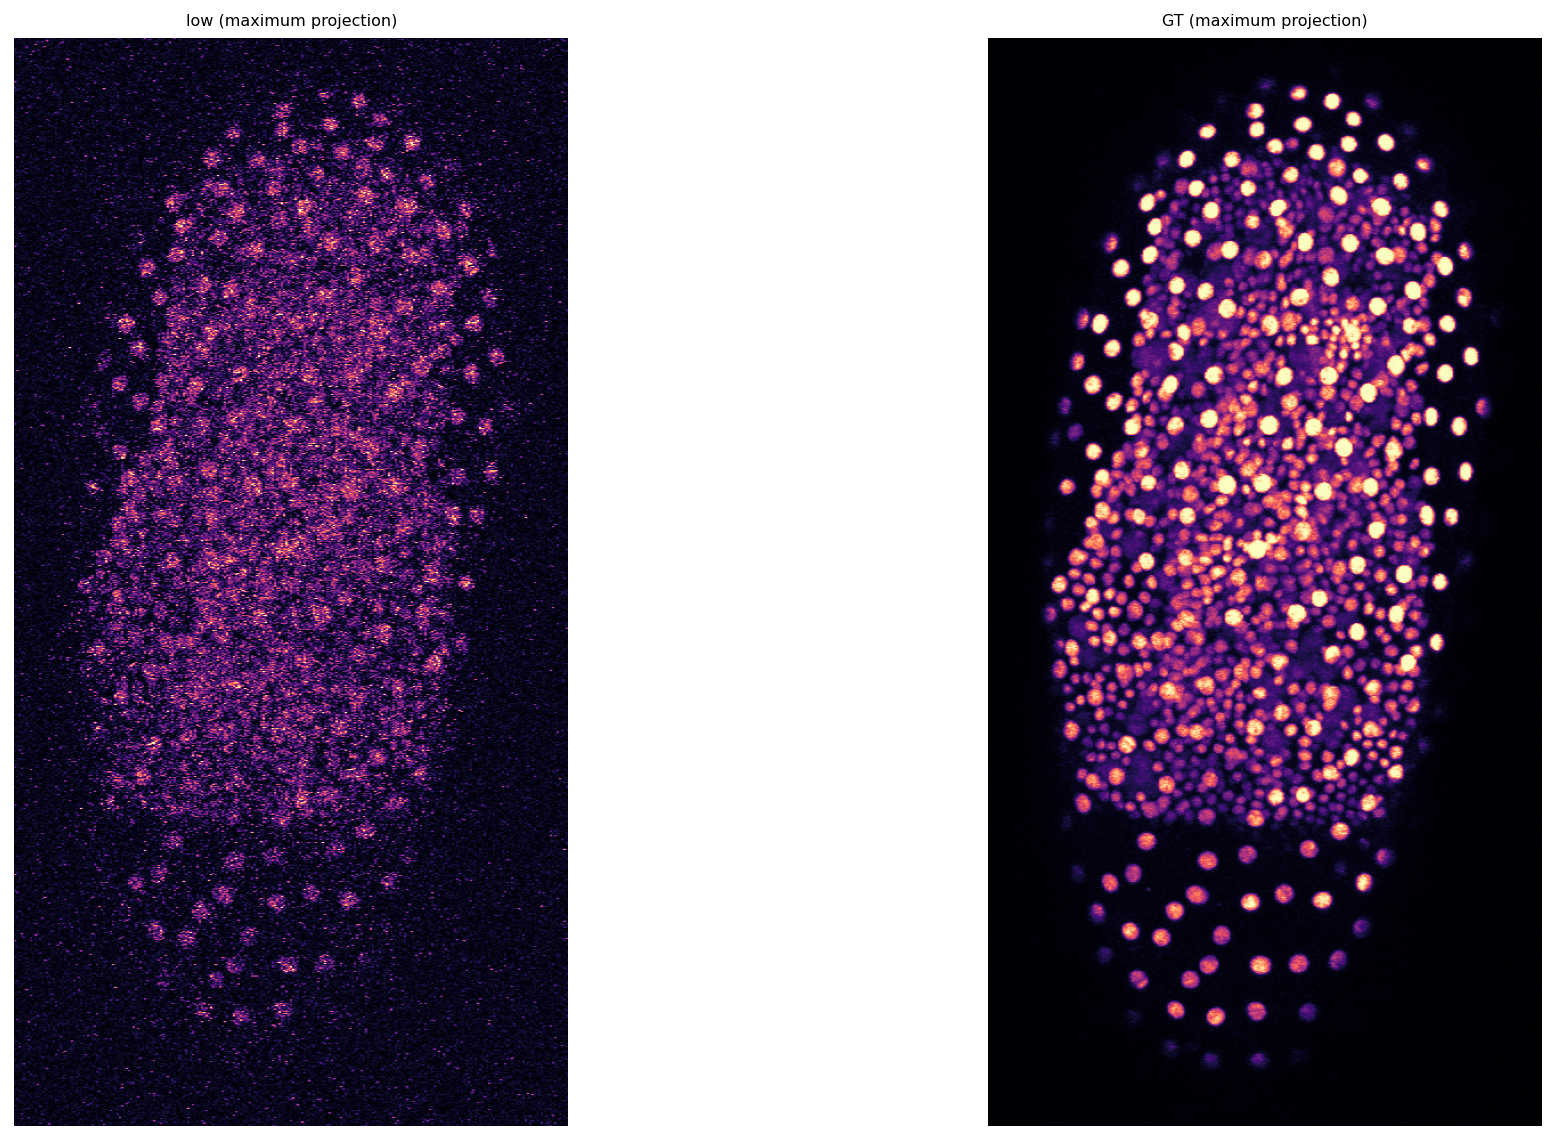

In [2]:
y = imread('data/tribolium/test/GT/nGFP_0.1_0.2_0.5_20_14_late.tif')
x = imread('data/tribolium/test/low/nGFP_0.1_0.2_0.5_20_14_late.tif')

axes = 'ZYX'
print('image size =', x.shape)
print('image axes =', axes)

plt.figure(figsize=(16,10))
plot_some(np.stack([x,y]),
          title_list=[['low (maximum projection)','GT (maximum projection)']], 
          pmin=2,pmax=99.8);

<hr style="height:2px;">

# CARE model

Load trained model (located in base directory `models` with name `my_model`) from disk.  
The configuration was saved during training and is automatically loaded when `CARE` is initialized with `config=None`.

In [3]:
model = CARE(config=None, name='my_model', basedir='models')

Loading network weights from 'weights_best.h5'.


2022-07-19 14:14:34.412472: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-07-19 14:14:34.430043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 14:14:34.430410: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:01.0 name: NVIDIA A40-16Q computeCapability: 8.6
coreClock: 1.74GHz coreCount: 84 deviceMemorySize: 15.82GiB deviceMemoryBandwidth: 648.29GiB/s
2022-07-19 14:14:34.430429: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-07-19 14:14:34.447161: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-07-19 14:14:34.447194: I tensorflow/stream_executor/platform/def

## Apply CARE network to raw image

Predict the restored image (image will be successively split into smaller tiles if there are memory issues).

In [4]:
%%time
restored = model.predict(x, axes)

2022-07-19 14:15:35.509646: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-19 14:15:35.509991: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2949995000 Hz
2022-07-19 14:15:36.393188: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-07-19 14:15:36.772650: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2022-07-19 14:15:37.337464: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-19 14:15:37.337496: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2022-07-19 14:15:37.337829: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-19 14:15:37.337874: W tensorflow/stream_executor/gpu/redzone_allocator.cc:31

Out of memory, retrying with n_tiles = (1, 2, 1)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.17it/s]

CPU times: user 12.5 s, sys: 1.91 s, total: 14.4 s
Wall time: 26.7 s


Alternatively, one can directly set `n_tiles` to avoid the time overhead from multiple retries in case of memory issues.

**Note**: *Out of memory* problems during `model.predict` can also indicate that the GPU is used by another process. In particular, shut down the training notebook before running the prediction (you may need to restart this notebook).

In [ ]:
#%%time
#restored = model.predict(x, axes, n_tiles=(1,4,4))

## Save restored image

Save the restored image stack as a ImageJ-compatible TIFF image, i.e. the image can be opened in ImageJ/Fiji with correct axes semantics.

In [5]:
Path('results').mkdir(exist_ok=True)
save_tiff_imagej_compatible('results/%s_nGFP_0.1_0.2_0.5_20_14_late.tif' % model.name, restored, axes)

<hr style="height:2px;">

# Raw low/high-SNR image and denoised image via CARE network

Plot the test stack pair and the predicted restored stack (middle).

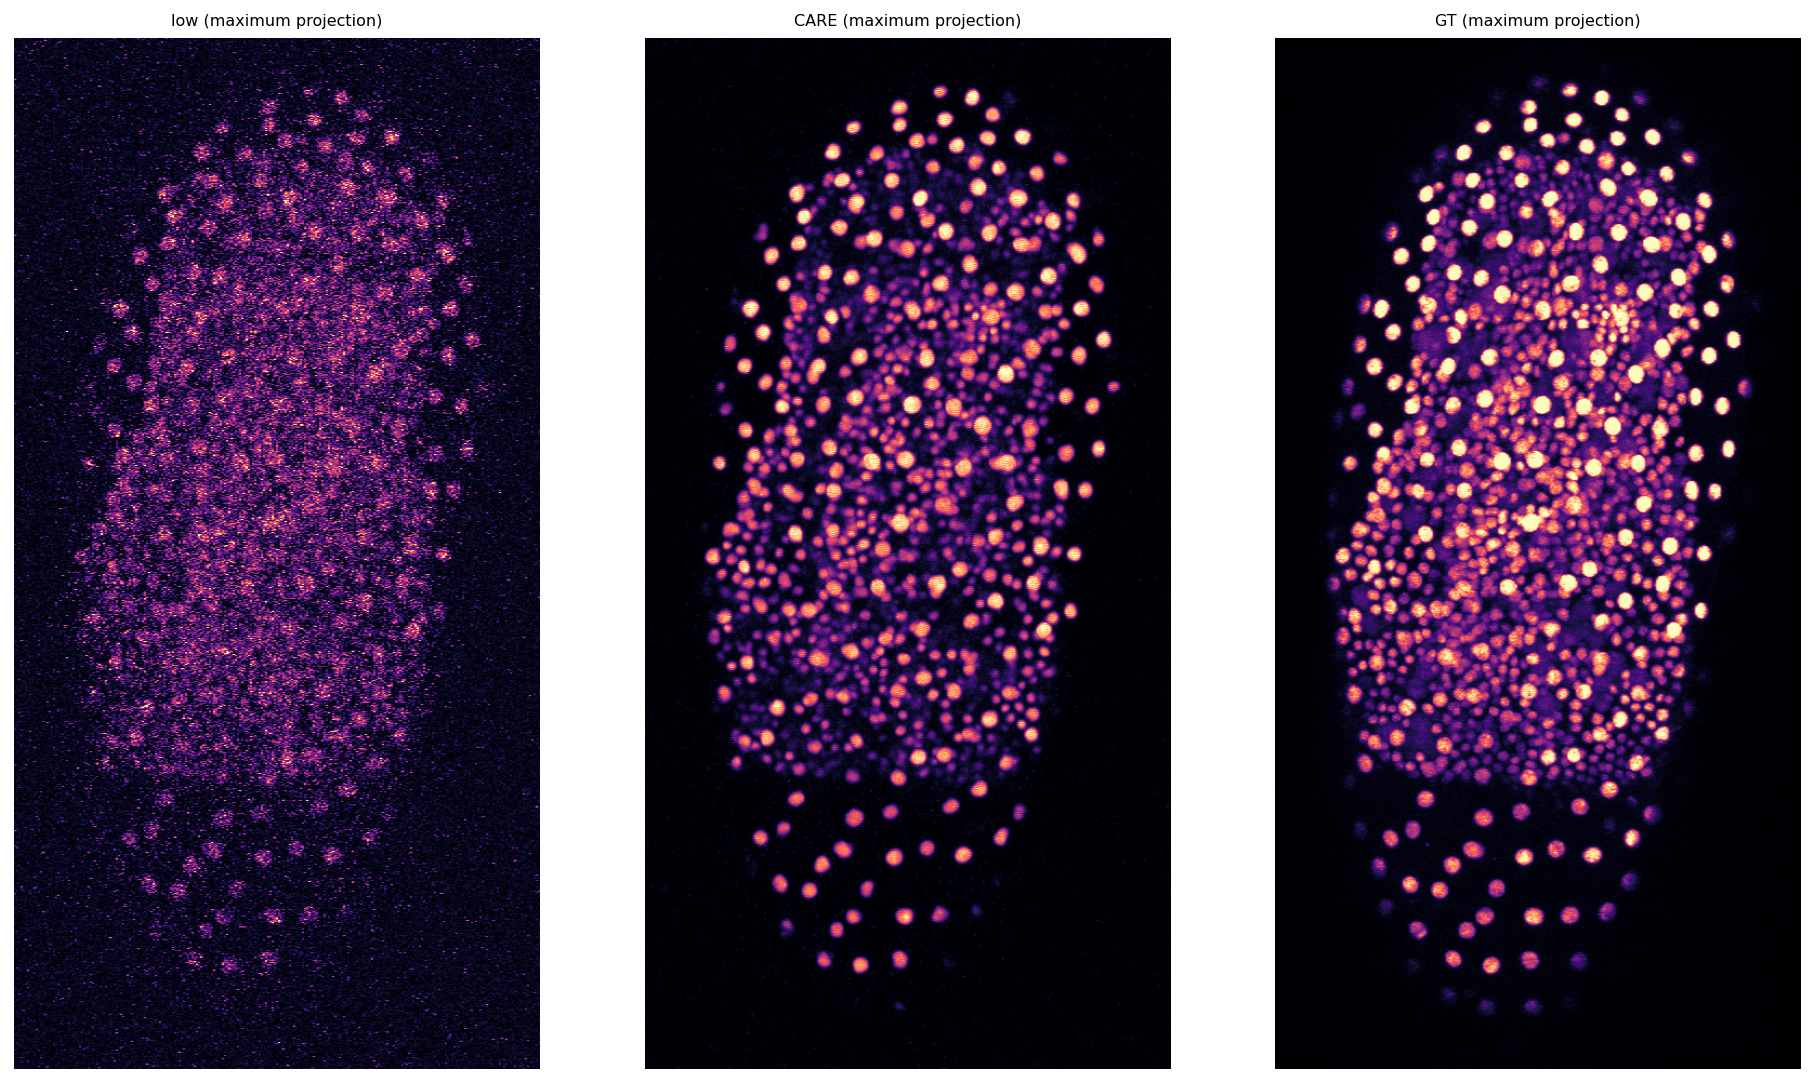

In [6]:
plt.figure(figsize=(16,10))
plot_some(np.stack([x,restored,y]),
          title_list=[['low (maximum projection)','CARE (maximum projection)','GT (maximum projection)']], 
          pmin=2,pmax=99.8);